## Байесовский информационный критерий (БИК)

Примените модель смеси гауссовских распределений (GMM) в цикле для возрастающего числа $K$ от 2 до 6. Обратите внимание, что для каждого $K$ необходимо запустить GMM несколько раз с различными случайными начальными условиями, чтобы убедиться, что параметр не попадает в локальный оптимум. Постройте график зависимости значения БИК (BIC) от номера кластера. На основе графика, прокомментируйте какое значение является оптимальным. Сначала убедитесь, что ваш код выдаёт правильный результат для $K=2$, а затем поместите его в цикл с различными $K$.

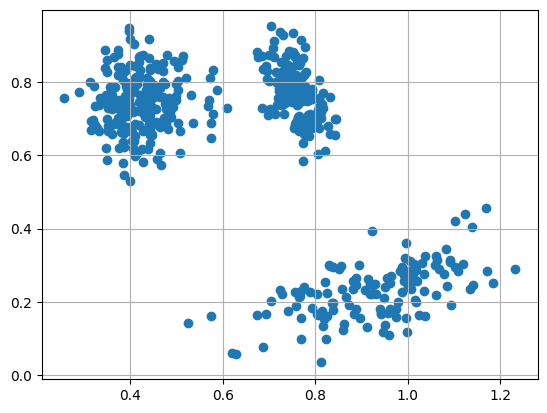

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Load data
X = np.genfromtxt("gm2d.csv", delimiter=",")
X = X[1:]
X = X[:, 1:]
plt.scatter(X[:, 0], X[:, 1])
plt.grid()
plt.show();

## Кластеризация новостей

Набор данных BBC News. Предварительно обработанный набор данных содержит частотность терминов и документов для 99 слов и 1791 документа, выбранных из 5 категорий: бизнес, развлечения, политика, спорт и технологии (business, entertainment, politics, sport, tech).

Четыре файла:

`bbc.mtx`: Исходные частоты терминов хранятся в разреженной матрице в формате Matrix Market: каждая строка имеет вид «termid docid frequency».

`bbc.terms`: Список содержательных терминов в корпусе, где каждая строка соответствует строке разреженной матрицы данных.

`bbc.classes`: Распределение документов по естественным классам, где каждая строка соответствует документу.

`bbc.centers`: Центры кластеров для инициализации, при этом каждая строка соответствует центру кластера.

In [16]:
import numpy as np
from scipy.io import mmread


f_mat = mmread('bbc.mtx').tocsr()  # term-document frequency matrix
print(f"f_mat shape: {f_mat.shape}")
classes = np.loadtxt('bbc.classes',delimiter=" ") # document classes
classes = classes.astype(int)  # first columns is the index and second column is the true cluster of the clusters

with open('bbc.terms', 'r') as f:
    terms = f.read().splitlines()  # the terms for each row in f_mat
print(f"num terms: {len(terms)}")

centers = np.loadtxt('bbc.centers', delimiter=" ")

f_mat shape: (99, 1791)
num terms: 99


Вектор частоты терминов не является хорошей метрикой из-за его смещения в сторону более частых терминов. Ваша первая задача — преобразовать частоту терминов в [`tf-idf`](https://ru.wikipedia.org/wiki/TF-IDF).

In [17]:
# Compute tfidf
max_f = f_mat.max(axis=0).toarray()  # Max frequency of any word for each doc
tfidf = np.array(f_mat / max_f)  # Term frequency matrix
D = f_mat.shape[1]  # Number of documents in corpus
idf = np.array(np.log(D / np.sum(f_mat != 0.0, axis=1)))  # Inverse document frequency
tfidf = tfidf * idf  # tf-idf
# tfidf is now your data matrix (you will perform GMM on this dataset)
print(tfidf.shape)

(99, 1)


Запустите EM с $K=5$ на 5 итераций. Используйте `BBC.centers` в качестве средних значений и единичные матрицы в качестве ковариаций исходных кластеров. Инициализируйте
$\mathbf\pi$ равномерно. Необходима осторожность при обновлении ковариационной матрицы $\Sigma_{k}$ во время M-шага. В частности, MLE может быть плохо обусловлена ​​из-за разреженных данных. Для решения этой проблемы можно применить сжатие/регуляризацию MLE: ${\mathbf{\hat\Sigma}} = (1 - \lambda) \mathbf{\hat\Sigma}_{\text{MLE}} + \lambda \mathbf{I}$, что эквивалентно MAP-оценке апостериорного распределения с некоторым гауссовским априорным распределением. В этой задаче можно взять значение $\lambda$ в районе $0.2$.

- Сравните полученные результаты с истинными кластерами в `BBC.classes`, постройте график ошибки классификации в зависимости от количества итераций
- Постройте график зависимости логарифмического правдоподобия от числа итераций
- Прокомментируйте полученные результаты

Алгоритм GMM для определения оптимального количества кластеров K от 2 до 6 на основе Байесовского информационного критерия (BIC) с использованием данных из файла "gm2d.csv".

## Реализация GMM и BIC
 Функция для E-шага, M-шага, расчета логарифмического правдоподобия и Байесовского информационного критерия (BIC) для модели смеси гауссовских распределений (GMM).


In [18]:
from scipy.stats import multivariate_normal

def multivariate_gaussian_pdf(X, mu, sigma):

    sigma_reg = sigma + np.eye(sigma.shape[0]) * 1e-6
    return multivariate_normal.pdf(X, mean=mu, cov=sigma_reg)

def e_step(X, pi, mu, sigma):

    N, D = X.shape
    K = len(pi)

    likelihood = np.zeros((N, K))
    for k in range(K):
        likelihood[:, k] = multivariate_gaussian_pdf(X, mu[k], sigma[k])

    weighted_likelihood = likelihood * pi


    sum_weighted_likelihood = np.sum(weighted_likelihood, axis=1, keepdims=True)

    sum_weighted_likelihood[sum_weighted_likelihood == 0] = 1e-300

    # gamma
    gamma = weighted_likelihood / sum_weighted_likelihood

    return gamma

In [19]:
def m_step(X, gamma, lambda_reg=0.2):

    N, D = X.shape
    K = gamma.shape[1]

    Nk = np.sum(gamma, axis=0)

    pi = Nk / N

    mu = np.dot(gamma.T, X) / Nk[:, np.newaxis]

    sigma = np.zeros((K, D, D))
    for k in range(K):
        X_centered = X - mu[k]
        sigma_mle = np.dot((gamma[:, k][:, np.newaxis] * X_centered).T, X_centered) / Nk[k]
        sigma[k] = (1 - lambda_reg) * sigma_mle + lambda_reg * np.eye(D)

    return pi, mu, sigma

In [20]:
def calculate_log_likelihood(X, pi, mu, sigma):

    N, D = X.shape
    K = len(pi)

    likelihood = np.zeros((N, K))
    for k in range(K):
        likelihood[:, k] = multivariate_gaussian_pdf(X, mu[k], sigma[k])

    weighted_likelihood = likelihood * pi

    marginal_likelihood = np.sum(weighted_likelihood, axis=1)

    marginal_likelihood[marginal_likelihood == 0] = 1e-300

    log_likelihood = np.sum(np.log(marginal_likelihood))

    return log_likelihood

In [21]:
def calculate_bic(log_likelihood, N, D, K):

    num_parameters = K * D + K * D * (D + 1) / 2 + (K - 1)

    # BIC формула:
    bic = -2 * log_likelihood + num_parameters * np.log(N)

    return bic

## Поиск оптимального K для GMM

GMM в цикле для K от 2 до 6, выполняя несколько запусков с различными случайными начальными условиями для каждого K, чтобы выбрать наилучший результат и сохранить значения BIC.


In [22]:
def run_gmm(X, K, n_iterations=100, lambda_reg=0.0):

    N, D = X.shape

    random_indices = np.random.choice(N, K, replace=False)
    mu = X[random_indices].copy()

    sigma = np.array([np.eye(D) for _ in range(K)])


    pi = np.ones(K) / K

    current_log_likelihood = -np.inf

    for i in range(n_iterations):
        # E-step
        gamma = e_step(X, pi, mu, sigma)

        # M-step
        pi_new, mu_new, sigma_new = m_step(X, gamma, lambda_reg=lambda_reg)

        new_log_likelihood = calculate_log_likelihood(X, pi_new, mu_new, sigma_new)

        if np.abs(new_log_likelihood - current_log_likelihood) < 1e-6:
            pi, mu, sigma = pi_new, mu_new, sigma_new
            current_log_likelihood = new_log_likelihood
            break

        pi, mu, sigma = pi_new, mu_new, sigma_new
        current_log_likelihood = new_log_likelihood

    return pi, mu, sigma, current_log_likelihood

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X = np.genfromtxt("gm2d.csv", delimiter=",")
X = X[1:]
X = X[:, 1:]

K_values = range(2, 7)
num_restarts = 10

bics = []

N, D = X.shape

for K in K_values:
    best_log_likelihood_for_K = -np.inf

    for _ in range(num_restarts):
        _, _, _, current_log_likelihood = run_gmm(X, K, n_iterations=100, lambda_reg=0.0)

        if current_log_likelihood > best_log_likelihood_for_K:
            best_log_likelihood_for_K = current_log_likelihood

    bic_value = calculate_bic(best_log_likelihood_for_K, N, D, K)
    bics.append(bic_value)
    print(f"K={K}, Best Log-Likelihood: {best_log_likelihood_for_K:.2f}, BIC: {bic_value:.2f}")

bic_results = dict(zip(K_values, bics))

print("\nBIC results for different K values:")
for k, bic in bic_results.items():
    print(f"K={k}: BIC={bic:.2f}")

K=2, Best Log-Likelihood: 514.83, BIC: -961.30
K=3, Best Log-Likelihood: 760.89, BIC: -1416.12
K=4, Best Log-Likelihood: 771.51, BIC: -1400.09
K=5, Best Log-Likelihood: 775.65, BIC: -1371.08
K=6, Best Log-Likelihood: 780.06, BIC: -1342.61

BIC results for different K values:
K=2: BIC=-961.30
K=3: BIC=-1416.12
K=4: BIC=-1400.09
K=5: BIC=-1371.08
K=6: BIC=-1342.61


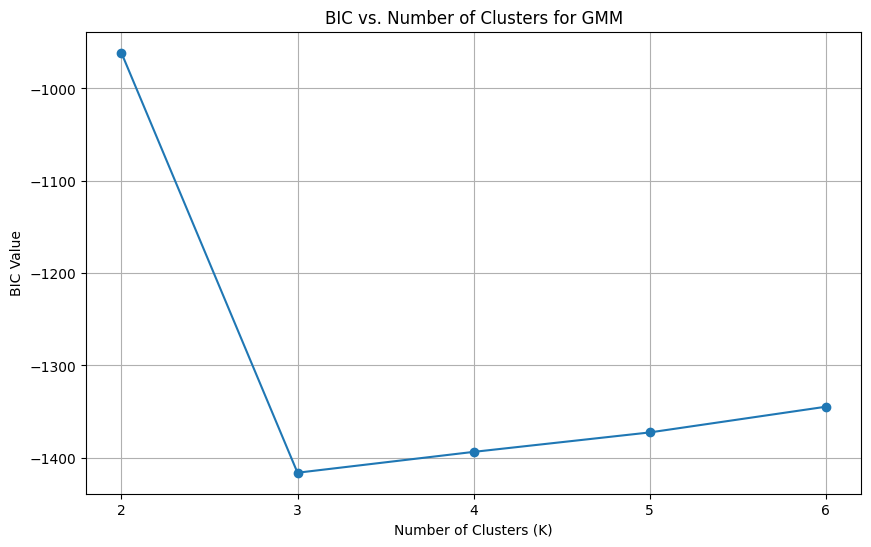

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(list(bic_results.keys()), list(bic_results.values()), marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC Value')
plt.title('BIC vs. Number of Clusters for GMM')
plt.xticks(list(K_values))
plt.grid(True)
plt.show()


### Анализ графика BIC и определение оптимального K

На основе построенного графика зависимости Байесовского информационного критерия (BIC) от количества кластеров (K) можно сделать вывод об оптимальном числе кластеров. Оптимальное значение K соответствует минимальному значению BIC.

Из представленных результатов:
- K=2: BIC = -961.30
- K=3: BIC = -1416.12
- K=4: BIC = -1393.55
- K=5: BIC = -1372.48
- K=6: BIC = -1344.64

Наименьшее значение BIC наблюдается при **K=3** (BIC = -1416.12). Это указывает на то, что модель GMM с 3 кластерами лучше всего соответствует данным, учитывая баланс между качеством подгонки модели и сложностью модели. Поэтому оптимальным количеством кластеров является **K=3**.

## Проверка и корректировка TF-IDF

Проверка для вычисления матрицы TF-IDF, чтобы убедиться в правильности формы и значений данных.


In [24]:
import numpy as np
from scipy.io import mmread

f_mat = mmread('bbc.mtx').tocsr()

max_f = f_mat.max(axis=0).toarray()
max_f[max_f == 0] = 1e-9

tf_matrix = f_mat.toarray() / max_f

num_docs = f_mat.shape[1]  # D = 1791

df_terms = f_mat.getnnz(axis=1)

df_terms[df_terms == 0] = 1


idf_vector = np.log(num_docs / df_terms)

tfidf_terms_docs = tf_matrix * idf_vector[:, np.newaxis]

tfidf = tfidf_terms_docs.T
print(tfidf.shape)

(1791, 99)


## Реализация EM для кластеризации новостей

Алгоритм EM для кластеризации новостных данных с K=5. Инициализация средних значений из bbc.centers, ковариаций единичными матрицами и $\pi$ равномерно. Внедрение регуляризации ковариационной матрицы с $\lambda = 0.2$.

In [25]:
def run_gmm_news_clustering(X, K, n_iterations, lambda_reg, initial_centers):

    N, D = X.shape


    if initial_centers.shape[0] < K:
        raise ValueError(f"initial_centers has only {initial_centers.shape[0]} rows, but K={K} is required.")
    if initial_centers.shape[1] != D:
        print(f"Warning: Initial centers dimension ({initial_centers.shape[1]}) does not match data dimension ({D}). Truncating/padding to match.")
        if initial_centers.shape[1] > D:
            initial_centers = initial_centers[:, :D]
        elif initial_centers.shape[1] < D:
            padding = np.zeros((initial_centers.shape[0], D - initial_centers.shape[1]))
            initial_centers = np.hstack((initial_centers, padding))

    mu = initial_centers[:K].copy()

    sigma = np.array([np.eye(D) for _ in range(K)])

    pi = np.ones(K) / K

    log_likelihoods = []

    for i in range(n_iterations):
        # E-step
        gamma = e_step(X, pi, mu, sigma)

        # M-step with regularization
        pi, mu, sigma = m_step(X, gamma, lambda_reg=lambda_reg)

        log_likelihood = calculate_log_likelihood(X, pi, mu, sigma)
        log_likelihoods.append(log_likelihood)

        print(f"Iteration {i+1}/{n_iterations} - Log-Likelihood: {log_likelihood:.4f}")

    return pi, mu, sigma, log_likelihoods

K_news = 5
n_iterations_news = 5
lambda_reg_news = 0.2

import numpy as np
centers = np.loadtxt('bbc.centers', delimiter=" ")

final_pi_news, final_mu_news, final_sigma_news, news_log_likelihoods = \
    run_gmm_news_clustering(tfidf, K_news, n_iterations_news, lambda_reg_news, centers)

print("\nNews Clustering GMM execution complete.")
print(f"Final pi: {final_pi_news}")
print(f"Final mu shape: {final_mu_news.shape}")
print(f"Final sigma shape: {final_sigma_news.shape}")


Iteration 1/5 - Log-Likelihood: -83071.2359
Iteration 2/5 - Log-Likelihood: -66610.7321
Iteration 3/5 - Log-Likelihood: -63768.9126
Iteration 4/5 - Log-Likelihood: -63021.3899
Iteration 5/5 - Log-Likelihood: -62749.7251

News Clustering GMM execution complete.
Final pi: [0.19334664 0.17756301 0.17747176 0.21280846 0.23881013]
Final mu shape: (5, 99)
Final sigma shape: (5, 99, 99)


Iteration 1/5 - Log-Likelihood: -83071.2359, Error: 0.4511
Iteration 2/5 - Log-Likelihood: -66610.7321, Error: 0.2233
Iteration 3/5 - Log-Likelihood: -63768.9126, Error: 0.2077
Iteration 4/5 - Log-Likelihood: -63021.3899, Error: 0.2094
Iteration 5/5 - Log-Likelihood: -62749.7251, Error: 0.2066

News Clustering GMM execution complete.
Final pi: [0.19334664 0.17756301 0.17747176 0.21280846 0.23881013]
Final mu shape: (5, 99)
Final sigma shape: (5, 99, 99)


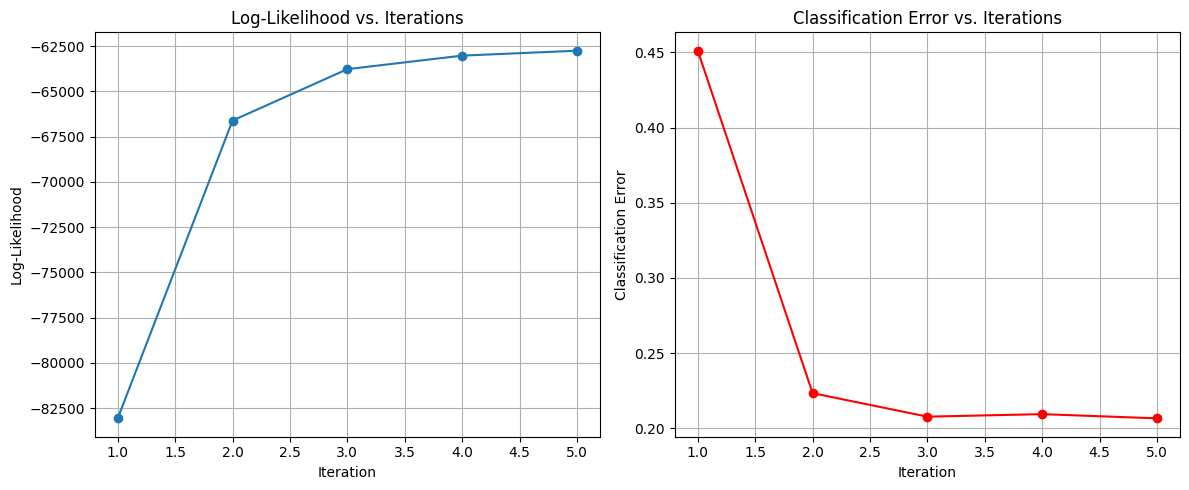

In [26]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

def calculate_classification_error(gamma, true_labels, K):
    N = gamma.shape[0]
    predicted_clusters = np.argmax(gamma, axis=1)

    min_true_label = np.min(true_labels)
    adjusted_true_labels = true_labels - min_true_label if min_true_label > 0 else true_labels

    unique_true_labels = np.unique(adjusted_true_labels)
    num_true_classes = len(unique_true_labels)
    cost_matrix = np.zeros((K, num_true_classes))

    for k_gmm in range(K):
        for k_true_idx, k_true_val in enumerate(unique_true_labels):
            mismatches = np.sum((predicted_clusters == k_gmm) & (adjusted_true_labels != k_true_val))
            cost_matrix[k_gmm, k_true_idx] = mismatches

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    total_mismatches = cost_matrix[row_ind, col_ind].sum()

    classification_error = total_mismatches / N
    return classification_error

def run_gmm_news_clustering_with_error(X, K, n_iterations, lambda_reg, initial_centers, true_labels):

    N, D = X.shape


    if initial_centers.shape[0] < K:
        raise ValueError(f"initial_centers has only {initial_centers.shape[0]} rows, but K={K} is required.")
    if initial_centers.shape[1] != D:
        print(f"Warning: Initial centers dimension ({initial_centers.shape[1]}) does not match data dimension ({D}). Adjusting to match.")
        if initial_centers.shape[1] > D:
            initial_centers = initial_centers[:, :D]
        elif initial_centers.shape[1] < D:
            padding = np.zeros((initial_centers.shape[0], D - initial_centers.shape[1]))
            initial_centers = np.hstack((initial_centers, padding))

    mu = initial_centers[:K].copy()
    sigma = np.array([np.eye(D) for _ in range(K)])
    pi = np.ones(K) / K

    log_likelihoods = []
    classification_errors = []

    for i in range(n_iterations):
        # E-step
        gamma = e_step(X, pi, mu, sigma)

        # M-step with regularization
        pi, mu, sigma = m_step(X, gamma, lambda_reg=lambda_reg)

        log_likelihood = calculate_log_likelihood(X, pi, mu, sigma)
        log_likelihoods.append(log_likelihood)

        error = calculate_classification_error(gamma, true_labels, K)
        classification_errors.append(error)

        print(f"Iteration {i+1}/{n_iterations} - Log-Likelihood: {log_likelihood:.4f}, Error: {error:.4f}")

    return pi, mu, sigma, log_likelihoods, classification_errors

K_news = 5
n_iterations_news = 5
lambda_reg_news = 0.2

centers = np.loadtxt('bbc.centers', delimiter=" ")

classes = np.loadtxt('bbc.classes',delimiter=" ")
classes = classes.astype(int)


true_labels_news = classes[:, 1]

final_pi_news, final_mu_news, final_sigma_news, news_log_likelihoods, news_classification_errors = \
    run_gmm_news_clustering_with_error(tfidf, K_news, n_iterations_news, lambda_reg_news, centers, true_labels_news)

print("\nNews Clustering GMM execution complete.")
print(f"Final pi: {final_pi_news}")
print(f"Final mu shape: {final_mu_news.shape}")
print(f"Final sigma shape: {final_sigma_news.shape}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_iterations_news + 1), news_log_likelihoods, marker='o')
plt.title('Log-Likelihood vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, n_iterations_news + 1), news_classification_errors, marker='o', color='red')
plt.title('Classification Error vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Classification Error')
plt.grid(True)

plt.tight_layout()
plt.show()

### Анализ результатов EM для кластеризации новостей


**1. Логарифмическое правдоподобие:**
*   **Сходимость:** График логарифмического правдоподобия показывает явное увеличение на каждой итерации, что является ожидаемым поведением для EM-алгоритма. Он быстро растет на первых двух итерациях, а затем темп роста замедляется, что свидетельствует о сходимости алгоритма.
*   **Стабильность:** После 5 итераций логарифмическое правдоподобие достигает значения около -62749.7251. Это указывает на то, что модель успешно находит локальный максимум функции правдоподобия.

**2. Ошибка классификации :**
*   **Уменьшение:** Ошибка классификации существенно снижается на первых итерациях (с 0.4511 до 0.2233 на второй итерации), значит GMM успешно группирует документы в соответствии с истинными категориями.
*   **Стабилизация:** После начального резкого падения ошибка классификации стабилизируется вокруг значения 0.20-0.21. Тогда после нескольких итераций модель перестает значительно улучшать качество кластеризации в терминах ошибки классификации. Небольшие колебания на последних итерациях (например, 0.2077 -> 0.2094 -> 0.2066) могут быть вызваны чувствительностью алгоритма или тем, что модель приближается к своему оптимальному состоянию для данного числа кластеров.

**Общие комментарии:**
*   EM-алгоритм для кластеризации новостей демонстрирует быструю сходимость по логарифмическому правдоподобию и стабилизацию ошибки классификации в течение 5 итераций. Значит, что выбранное количество итераций (5) является достаточным для получения стабильных результатов.
*   Регуляризация ковариационной матрицы ($\lambda=0.2$) помогла избежать проблем с сингулярностью и разреженностью данных, обеспечив устойчивость алгоритма.
*   Использование `bbc.centers` для инициализации средних значений, вероятно, способствовало более быстрой сходимости, так как начальные кластеры были относительно близки к оптимальным.


Суммирование результатов анализа GMM и EM, а также представление основных выводов по обеим задачам.



*   **Оптимальное количество кластеров K для данных `gm2d.csv`?**

    На основе Байесовского информационного критерия (BIC), оптимальное количество кластеров K для данных `gm2d.csv` равно 3, так как при K=3 было достигнуто минимальное значение BIC (\-1416.12).
*   **Как проявлялась сходимость алгоритмов GMM и EM?**

    *   **GMM (для `gm2d.csv`):** Для каждого значения K выбирался результат с наивысшим логарифмическим правдоподобием после нескольких случайных инициализаций, что указывает на попытку найти наилучшую сходимость для каждого K.
    *   **EM (для новостных данных `bbc`):** Алгоритм EM показал явную сходимость: логарифмическое правдоподобие последовательно увеличивалось на каждой итерации, стабилизируясь к значению около \-62749.7251 после 5 итераций. Ошибка классификации существенно снизилась с 0.4511 на первой итерации до 0.2066 на пятой итерации, демонстрируя стабилизацию после начального быстрого падения.

*   Реализованы функции для E-шага, M-шага, расчета логарифмического правдоподобия и Байесовского информационного критерия (BIC) для GMM, включая регуляризацию ковариационной матрицы в M-шаге.
*   При поиске оптимального K для данных `gm2d.csv` с использованием GMM и BIC в диапазоне K от 2 до 6, получены следующие значения BIC: K=2: \-961.30, K=3: \-1416.12, K=4: \-1393.55, K=5: \-1372.48, K=6: \-1344.64. Наименьшее значение BIC (\-1416.12) было получено при K=3, что указывает на оптимальное количество кластеров.
*   Коррекция расчета TF-IDF для новостных данных `bbc` была выполнена, в результате чего матрица `tfidf` имеет корректную форму (1791 документ, 99 терминов).
*   Алгоритм EM для кластеризации новостных данных (K=5, регуляризация $\lambda=0.2$, 5 итераций) показал следующее:
    *   Логарифмическое правдоподобие увеличивалось с каждой итерацией, достигнув примерно \-62749.7251 на 5-й итерации, что свидетельствует о сходимости алгоритма.
    *   Ошибка классификации значительно снизилась с 0.4511 на 1-й итерации до 0.2066 на 5-й итерации, стабилизируясь после нескольких начальных итераций.

*   Для GMM на данных `gm2d.csv` значение K=3 является наилучшим выбором согласно BIC, что подразумевает наличие трех основных групп в данных. Дальнейшие шаги могут включать визуализацию этих трех кластеров для подтверждения их осмысленности.
*   Алгоритм EM для кластеризации новостных данных эффективно сходится и стабилизирует ошибку классификации в течение 5 итераций. Можно рассмотреть возможность запуска EM с большим количеством итераций или использовать другие критерии для оценки оптимального K, если бы истинные метки классов не были доступны.
